Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Vincent Kim"
COLLABORATORS = ""

---

---
# PageRank

PageRank is a function that assigns a real number to each page in the Web (or at least to that portion of the Web that has been crawled and its links discovered). The intent is that the higher the PageRank of a page, the more "important" it is.

Hadoop has its origins in Apache Nutch, an open source web search engine, and one of the first use cases for Big Data technologies and MapReduce was the indexing of millions of webpages. In the following application, we will delve into an implementation of an iterative algorithm, the PageRank, which is well suited to Spark.

We will deal with the following simplified web system :

![](pagerank.png)

We have four web pages (a, b, c, and d) in our system :

* Web page A has outbound links to pages B, C, D
* Web page B has outbound links to C, D
* Web page C has outbound link to B
* Web page D has outbound link to A, C

We will implement a [simpler version of PageRank](https://en.wikipedia.org/wiki/PageRank#Simplified_algorithm) in PySpark.

In [1]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName('lecture-lyon2').setMaster('local')
sc = SparkContext.getOrCreate(conf=conf)
sc

<SparkContext master=local appName=lecture-lyon2>

In [2]:
from pyspark.rdd import RDD

import pandas as pd
%matplotlib inline

---
## Input Data

When crawling the Web for URLs and their neighbors, we will append all the new data in the same file. As such we expect the format to be the following when reading from the filesystem, which is easier to append on :

```
URL1         neighbor1
URL1         neighbor2
URL2         neighbor1
...
```

We prefer to work on a data structure where all neighbors of the same URL are grouped on one line:

```
URL1   [neighbor1, neighbor2]
URL2   [neighbor1]
...
```

Let's build two functions to alternate between both representations.

# Question

Generate a web system as an RDD of tuples (page name, neighbor page name) from a RDD of tuples (page name, list of all neighbors).

_Hint: we are working with PairedRDDs here, don't hesitate to check the [API reference](https://spark.apache.org/docs/2.2.0/api/python/pyspark.html#pyspark.RDD) of RDDs for functions like `mapValues` or `flatMapValues`_

In [7]:
def ungroup_input(sc, system):
    """
    Generate the websystem as an RDD of tuples (page, neighbor page)
    """
    return system.flatMapValues(lambda x: x)
    raise NotImplementedError()

In [8]:
"""
Graded cell

2 points
"""
system = sc.parallelize([
        ('a', ['b','c','d']),
        ('c', ['b']), 
        ('b', ['c','d']), 
        ('d', ['a','c'])
    ])
result = ungroup_input(sc, system).collect()
assert result == [
    ('a', 'b'), ('a', 'c'), ('a', 'd'), 
    ('c', 'b'), 
    ('b', 'c'), ('b', 'd'), 
    ('d', 'a'), ('d', 'c')
]

# Question

The inverse of the previous question.

_Hint: don't hesitate to collect and print your RDD. You may most notably find out that `pyspark.resultiterable.ResultIterable
` is not the result we want_

In [33]:
def group_input(sc, system):
    """
    Generate the websystem as an RDD of tuples (page, list of neighbors)
    """
    return system.groupByKey().mapValues(list)
    raise NotImplementedError()
system = sc.parallelize([('a', 'b'), ('a', 'c'), ('a', 'd'), ('c', 'b'), ('b', 'c'), ('b', 'd'), ('d', 'a'), ('d', 'c')])
group_input(sc, system)

PythonRDD[105] at RDD at PythonRDD.scala:53

In [34]:
"""
Graded cell

2 points
"""
system = sc.parallelize([('a', 'b'), ('a', 'c'), ('a', 'd'), ('c', 'b'), ('b', 'c'), ('b', 'd'), ('d', 'a'), ('d', 'c')])
result = group_input(sc, system).collect()
assert result == [
        ('a', ['b','c','d']),
        ('c', ['b']), 
        ('b', ['c','d']), 
        ('d', ['a','c'])
    ]

---
## Page contributions

At each iteration, we need to compute URL contributions to the rank of other URLs. The PageRank transferred from a given page to the targets of its outbound links upon the next iteration is divided equally among all outbound links.

$$Contribution\ to\ a\ page = \frac{pagerank\ of\ contributing\ page}{number\ outbound\ links\ from\ contributing\ page}$$

Then, for a page, we will sum the contribution of every page linking to the page.

Finally, the update pagerank for a page, given a damping factor $s$ will be :

$$ pagerank(u) = 1 - s + s \times \sum_{v \in B_u} \frac{pagerank(v)}{L(v)} $$

i.e. the PageRank value for a page $u$ is dependent on the PageRank values for each page $v$ contained in the set $B_u$ (the set containing all pages linking to page $u$), divided by the number $L(v)$ of links from page $v$.

<hr>

# Question

First, we are going to build the page contribution of a page to a set of outbound urls in `computeContribs(urls, rank)`. The first arugment gives the outbound links of a page, the second argument gives the rank of the page, and we return a list of tuples (outbound url, contribution to the outbound url).

In [108]:
import fractions

In [169]:
def computeContribs(urls, rank):
    """
    Calculates URL contributions to the rank of other URLs.
    """
    rdd = sc.parallelize(urls)
    rdd_count = rdd.count()
    #counts_by_key = rdd.countByKey()
    #return sc.parallelize(urls).map(lambda x: (x, Fraction(rank, rdd_count))).collect()
    return sc.parallelize(urls).map(lambda x: (x, rank/rdd_count)).collect()
    raise NotImplementedError()
    
print(computeContribs(['b', 'c', 'd'], 1))
#print([('b', Fraction(1/3)), ('c', Fraction(1/3)), ('d', Fraction(1/3))])

[('b', 0.3333333333333333), ('c', 0.3333333333333333), ('d', 0.3333333333333333)]


In [99]:
"""
Graded cell

2 points
"""
assert computeContribs(['b', 'c', 'd'], 1) == [('b', 1/3), ('c', 1/3), ('d', 1/3)]

AssertionError: 

# Question

Build a RDD of contributions, which is an RDD of tuples (URL, contributed rank from some page) using the links and ranks RDD.

Following is the structure of each RDD :

* links RDD

```
page1    [list of neighbors to page1]
page2    [list of neighbors to page2]
...
```

* ranks RDD

```
page1    rank1
page2    rank2
...
```

In [351]:
def generate_contributions(sc, links, ranks):
    """
    Calculates URL contributions to the rank of other URLs.
    """
    counts_by_key = links.flatMapValues(lambda x: x).countByKey()
    contributions = links.flatMapValues(lambda x: x).join(ranks)
    contributions = contributions.map(lambda x: (x[0], x[1])).map(lambda x: (x[1][0], x[1][1], x[0]))
    
    #print(counts_by_key)
    #contributions = contributions.join(counts_by_key)
    
    contributions = contributions.map(lambda x: (x[0], (x[1] / (counts_by_key[x[2]]))))
    
    #print(contributions.collect())
    return contributions
    raise NotImplementedError()
    

links = sc.parallelize([
        ('a', ['b','c','d']),
        ('c', ['b']), 
        ('b', ['c','d']), 
        ('d', ['a','c'])
    ])

ranks = sc.parallelize([
        ('a', 1.0),
        ('c', 3.0), 
        ('b', 2.0), 
        ('d', 4.0)
])

print(generate_contributions(sc, links, ranks).collect())

[('b', 3.0), ('c', 1.0), ('d', 1.0), ('a', 2.0), ('c', 2.0), ('b', 0.3333333333333333), ('c', 0.3333333333333333), ('d', 0.3333333333333333)]


In [164]:
"""
Graded cell

2 points
"""
links = sc.parallelize([
        ('a', ['b','c','d']),
        ('c', ['b']), 
        ('b', ['c','d']), 
        ('d', ['a','c'])
    ])

ranks = sc.parallelize([
        ('a', 1.0),
        ('c', 3.0), 
        ('b', 2.0), 
        ('d', 4.0)
])

assert generate_contributions(sc, links, ranks).collect() == [
    ('b', 3.0), # contribution from c
    ('c', 1.0), ('d', 1.0), # contribution from b
    ('a', 2.0), ('c', 2.0), # contribution from d
    ('b', 1/3), ('c', 1/3), ('d', 1/3) # contribution from a 
]

AssertionError: 

# Question

Compute new ranks for each URL by summing all contributions from outbound URL, and applying the damping factor.

In [252]:
def generate_ranks(sc, contributions, damping):
    """
    Calculates URL contributions to the rank of other URLs.
    """
    contributions_received = contributions.foldByKey(0, lambda x,y: x + y)
    return contributions.join(contributions_received).map(lambda x: (x[0], 1 - damping + damping * x[1][1]))
    
    raise NotImplementedError()
    
contributions = sc.parallelize([
    ('b', 3.0), 
    ('c', 1.0), ('d', 1.0), 
    ('a', 2.0), ('c', 2.0), 
    ('b', 1/3), ('c', 1/3), ('d', 1/3) 
])
#contributions.collect()
generate_ranks(sc, contributions, 0.85).collect()

[('b', 2.9833333333333334),
 ('b', 2.9833333333333334),
 ('c', 2.9833333333333334),
 ('c', 2.9833333333333334),
 ('c', 2.9833333333333334),
 ('d', 1.2833333333333332),
 ('d', 1.2833333333333332),
 ('a', 1.85)]

In [253]:
"""
Graded cell

2 points
"""
contributions = sc.parallelize([
    ('b', 3.0), 
    ('c', 1.0), ('d', 1.0), 
    ('a', 2.0), ('c', 2.0), 
    ('b', 1/3), ('c', 1/3), ('d', 1/3) 
])

result = generate_ranks(sc, contributions, 0.85).collect() 

assert [v for k,v in result if k == 'a'][0] == 1.85
assert [v for k,v in result if k == 'b'][0] - 2.98 < 0.1
assert [v for k,v in result if k == 'c'][0] - 2.98 < 0.1
assert [v for k,v in result if k == 'd'][0] - 1.28 < 0.1

---
## Algorithm

Let's build the iteration. At each step :

1. Generate all contributions
2. Generate and update ranks RDD

# Question

Let's create a Pandas dataframe with schema \[a, b, c, d\]. At each iteration, add a row with Pagerank value for each node in the corresponding column. Return the Pandas dataframe as a result so we can investigate it.

In [352]:
def initialize(sc):
    """
    Initialize links and ranks RDDs
    """
    # Loads all URLs from input file and initialize their neighbors.
    links = sc.parallelize([('a', 'b'), ('a', 'c'), ('a', 'd'), ('c', 'b'), ('b', 'c'), ('b', 'd'), ('d', 'a'), ('d', 'c')])
    links = group_input(sc, links).cache() # put the links RDD in cache because it will be reused a lot

    # Initialize all ranks to 0.25
    ranks = links.keys().map(lambda url: (url, 0.25))
    
    return (links, ranks)

In [397]:
def main(sc, iterations, damping, links, ranks):
    """
    Main logic. Return pandas dataframe with appended pageranks for each node in order of iterations.
    
    Example: 
    Index A B C D
    1     1 2 3 4   <-- iteration 1
    2     2 3 4 5   <-- iteration 2
    ...
    """
    columns = ['a', 'b', 'c', 'd']
    pageranks = {
        'a':[0.25], 'b':[0.25], 'c':[0.25], 'd':[0.25]
    }
    pageranks = sc.parallelize(pageranks.items()).map(lambda x: (x[0], (0, x[1][0])))
    #df_start = pd.DataFrame(pageranks.collectAsMap(), columns=columns).copy()
    #print(pageranks.collect())
    df = pd.DataFrame(pageranks.collectAsMap(), columns=columns)
    for iteration in range(iterations):
        print("At iteration %s" % (iteration + 1))
        contributions = generate_contributions(sc, links, ranks)
        #need to update ranks values
        ranks = generate_ranks(sc, contributions, damping)
        pageranks_row = generate_ranks(sc, contributions, damping).map(lambda x: (x[0], [iteration + 1, x[1]]))
        pageranks = pageranks.union(pageranks_row)
        print(pageranks_row.collect())
        #raise NotImplementedError()
        #pageranks.collect()
        #pageranks = pageranks.collectAsMap()
        #print(pageranks.collect())
        df_row = pd.DataFrame(pageranks_row.collectAsMap(), columns=columns)
        df = pd.concat([df, df_row.iloc[[1]]]).reset_index(drop=True)
    df = df.iloc[1:]
    #return pd.DataFrame(pageranks.collectAsMap(), columns=columns)
    return df

links, ranks = initialize(sc)
result = main(sc, 2, 0.85, links, ranks)
#print(result.to_dict()['a'][1])
#print(result.to_dict()['b'][1])
#print(result.to_dict()['c'][1])
#print(result.to_dict()['d'][1])
result.head()
#result.plot()

At iteration 1
[('b', [1, 0.43333333333333335]), ('b', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('a', [1, 0.25625000000000003]), ('d', [1, 0.32708333333333334]), ('d', [1, 0.32708333333333334])]
At iteration 2
[('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('d', [2, 0.5909375000000001]), ('d', [2, 0.5909375000000001]), ('d', [2, 0.5909375000000001]), ('a', [2, 0.42802083333333335]), ('a', [2, 0.42802083333333335])]


,a,b,c,d
1,0.250000,0.250000,0.250000,0.250000
2,0.256250,0.433333,0.433333,0.327083
3,0.428021,1.327604,0.868958,0.590938


In [344]:
"""
Graded cell

5 points
"""
links, ranks = initialize(sc)
result = main(sc, 1, 0.85, links, ranks)

assert result.to_dict()['a'][1] == 0.25625
assert result.to_dict()['b'][1] - (0.1 + 1/3) < 0.1
assert result.to_dict()['c'][1] - (0.1 + 1/3) < 0.1
assert result.to_dict()['d'][1] - 0.327083 < 0.1

At iteration 1
defaultdict(<class 'int'>, {'a': 3, 'c': 1, 'b': 2, 'd': 2})
[('b', 0.25), ('c', 0.125), ('d', 0.125), ('a', 0.125), ('c', 0.125), ('b', 0.08333333333333333), ('c', 0.08333333333333333), ('d', 0.08333333333333333)]
[('a', [0.25]), ('b', [0.25]), ('c', [0.25]), ('d', [0.25]), ('b', [0, 0.43333333333333335]), ('b', [0, 0.43333333333333335]), ('c', [0, 0.43333333333333335]), ('c', [0, 0.43333333333333335]), ('c', [0, 0.43333333333333335]), ('a', [0, 0.25625000000000003]), ('d', [0, 0.32708333333333334]), ('d', [0, 0.32708333333333334])]


AssertionError: 

At iteration 1
[('b', [1, 0.43333333333333335]), ('b', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('a', [1, 0.25625000000000003]), ('d', [1, 0.32708333333333334]), ('d', [1, 0.32708333333333334])]
At iteration 2
[('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('d', [2, 0.5909375000000001]), ('d', [2, 0.5909375000000001]), ('d', [2, 0.5909375000000001]), ('a', [2, 0.42802083333333335]), ('a', [2, 0.42802083333333335])]
At iteration 3
[('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('a', [3, 0.903445312

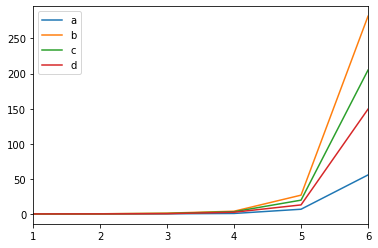

In [399]:
# I am generous, let me plot the DataFrame of pagerank evolution for you :)
# beware, this cell takes a long time to run
links, ranks = initialize(sc)
result = main(sc, 5, 0.85, links, ranks)
result.head()
result.plot()

In [387]:
# I am generous, let me plot the DataFrame of pagerank evolution for you :)
# beware, this cell takes a long time to run
links, ranks = initialize(sc)
result = main(sc, 25, 0.85, links, ranks)
result.plot()

At iteration 1
[('b', [1, 0.43333333333333335]), ('b', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('c', [1, 0.43333333333333335]), ('a', [1, 0.25625000000000003]), ('d', [1, 0.32708333333333334]), ('d', [1, 0.32708333333333334])]
At iteration 2
[('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('b', [2, 1.3276041666666667]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('c', [2, 0.8689583333333334]), ('d', [2, 0.5909375000000001]), ('d', [2, 0.5909375000000001]), ('d', [2, 0.5909375000000001]), ('a', [2, 0.42802083333333335]), ('a', [2, 0.42802083333333335])]
At iteration 3
[('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('b', [3, 4.085618055555556]), ('a', [3, 0.903445312

At iteration 7


KeyboardInterrupt: 

In [ ]:
sc.stop()